In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm

from thirdparty.fem_2d_rec import fem_poisson_solver,mesh_fem_2d_rec,get_matrices_2d
from common.util import create_boundary_mask, create_interior_mask, Dirichlet_bc_tensor, Dirichlet_bc_array
from models.autoencoder import Autoencoder

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Step 0: Generate FEM solutions

In [3]:
def generate_fem_u_matrices(f_values, input_shape, u_file_name, f_file_name):
    a, b, k, M = 0, 1, 1, 255
    c4n, n4e, n4db, ind4e = mesh_fem_2d_rec(a, b, a, b, M, M, k)
    M_R, Srr_R, Sss_R, Dr_R, Ds_R = get_matrices_2d(k)
    f_matrices = []
    u_matrices = []

    for f_value in tqdm(f_values, desc="Generating FEM solutions"):
        f = lambda x: np.full(x.shape[0], f_value)
        u_D = lambda x: x[:, 0] * 0
        fem_u = fem_poisson_solver(c4n, n4e, n4db, ind4e, k, M_R, Srr_R, Sss_R, f, u_D)
        fem_u_reshaped = fem_u.reshape(input_shape)
        f_matrix = np.full(input_shape, f_value)
        # f_matrix = Dirichlet_bc_array(f_matrix)
        u_matrices.append(fem_u_reshaped)
        f_matrices.append(f_matrix)

    u_matrices = np.array(u_matrices)
    f_matrices = np.array(f_matrices)
    np.save(u_file_name, u_matrices)
    np.save(f_file_name, f_matrices)
    print(f"Saved {len(u_matrices)} u matrices to {u_file_name}")
    print(f"Saved {len(f_matrices)} f matrices to {f_file_name}")
    return u_matrices, f_matrices

In [4]:
f_values = np.arange(-5000, 5000, 2)
input_shape = (256, 256)
u_file_name = './u_dataset.npy'
f_file_name = './f_dataset.npy'

In [5]:
u_matrices, f_matrices = generate_fem_u_matrices(f_values, input_shape, u_file_name, f_file_name)
print(f"Generated {len(u_matrices)} u matrices and f matrices")

Generating FEM solutions:   0%|          | 0/5000 [00:00<?, ?it/s]

Generating FEM solutions: 100%|██████████| 5000/5000 [1:13:14<00:00,  1.14it/s]


Saved 5000 u matrices to ./u_dataset.npy
Saved 5000 f matrices to ./f_dataset.npy
Generated 5000 u matrices and f matrices


# Step 1: VAE Model

In [5]:
class PoissonDataset(Dataset):
    def __init__(self, u_matrices):
        self.u_matrices = u_matrices

    def __len__(self):
        return len(self.u_matrices)

    def __getitem__(self, idx):
        u_matrix = self.u_matrices[idx]
        u_tensor = torch.tensor(u_matrix).unsqueeze(0).float()  # (1, H, W) 형태로 변환
        return u_tensor

u_matrices = np.load(f'./{u_file_name}')
dataset = PoissonDataset(u_matrices)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

In [6]:
class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 32 * 32, 512),
            nn.ReLU()
        )
        
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)
        
        self.fc_dec = nn.Linear(latent_dim, 512)
        
        self.decoder = nn.Sequential(
            nn.Linear(512, 128 * 32 * 32),
            nn.ReLU(),
            nn.Unflatten(1, (128, 32, 32)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            # nn.ReLU()
        )
    
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = self.fc_dec(z)
        return self.decoder(h)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar, z

In [7]:
def he_weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [8]:
def vae_loss(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

/home/fned/anaconda3/envs/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  1%|          | 1/100 [00:09<15:55,  9.65s/it]

Loss: 2.1426360121123246e+19


  2%|▏         | 2/100 [00:17<14:15,  8.73s/it]

Loss: 21115653675.348244


  3%|▎         | 3/100 [00:25<13:40,  8.46s/it]

Loss: 15625745061.214058


  4%|▍         | 4/100 [00:33<13:19,  8.33s/it]

Loss: 13170372111.539936


  5%|▌         | 5/100 [00:42<13:07,  8.28s/it]

Loss: 11667320910.517572


  6%|▌         | 6/100 [00:50<12:54,  8.24s/it]

Loss: 10253089809.175718


  7%|▋         | 7/100 [00:58<12:47,  8.25s/it]

Loss: 9120955187.527157


  8%|▊         | 8/100 [01:06<12:41,  8.27s/it]

Loss: 8111460964.600639


  9%|▉         | 9/100 [01:15<12:31,  8.25s/it]

Loss: 7250471959.71885
Loss: 6205266507.246006


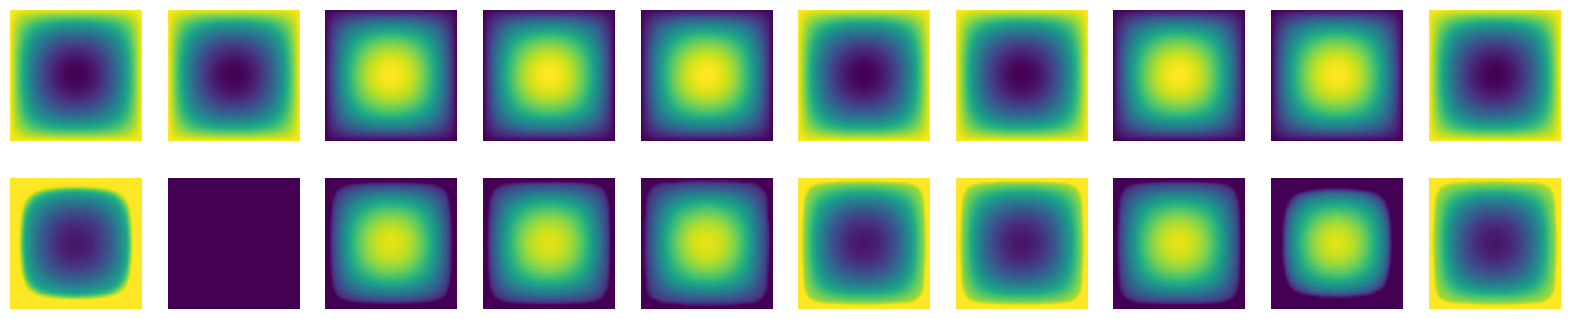

 11%|█         | 11/100 [01:31<12:15,  8.26s/it]

Loss: 5398443586.249201


 12%|█▏        | 12/100 [01:39<12:06,  8.25s/it]

Loss: 4736162768.971246


 13%|█▎        | 13/100 [01:48<11:57,  8.25s/it]

Loss: 4039783857.5846643


 14%|█▍        | 14/100 [01:56<11:46,  8.22s/it]

Loss: 3522663057.0734825


 15%|█▌        | 15/100 [02:04<11:38,  8.21s/it]

Loss: 3209297752.3833866


 16%|█▌        | 16/100 [02:12<11:29,  8.20s/it]

Loss: 2693086434.3003197


 17%|█▋        | 17/100 [02:21<11:24,  8.24s/it]

Loss: 2210105719.335463


 18%|█▊        | 18/100 [02:29<11:16,  8.25s/it]

Loss: 1814656895.2971246


 19%|█▉        | 19/100 [02:37<11:08,  8.25s/it]

Loss: 1553745085.942492
Loss: 1307473640.3322685


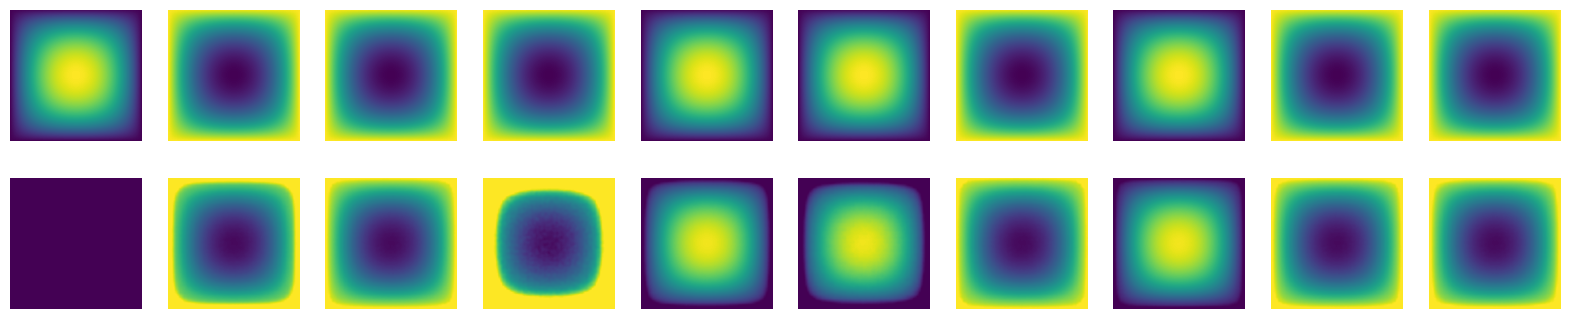

 21%|██        | 21/100 [02:54<10:53,  8.27s/it]

Loss: 1194356193.6485622


 22%|██▏       | 22/100 [03:02<10:40,  8.22s/it]

Loss: 1042582648.140575


 23%|██▎       | 23/100 [03:10<10:31,  8.20s/it]

Loss: 893130542.5686901


 24%|██▍       | 24/100 [03:18<10:21,  8.18s/it]

Loss: 857444664.3578274


 25%|██▌       | 25/100 [03:26<10:15,  8.21s/it]

Loss: 785676832.9009584


 26%|██▌       | 26/100 [03:35<10:09,  8.24s/it]

Loss: 697940371.9840256


 27%|██▋       | 27/100 [03:43<09:57,  8.19s/it]

Loss: 814811167.5399361


 28%|██▊       | 28/100 [03:51<09:49,  8.19s/it]

Loss: 783931526.5623003


 29%|██▉       | 29/100 [03:59<09:40,  8.17s/it]

Loss: 799151642.3913738
Loss: 760138407.5686901


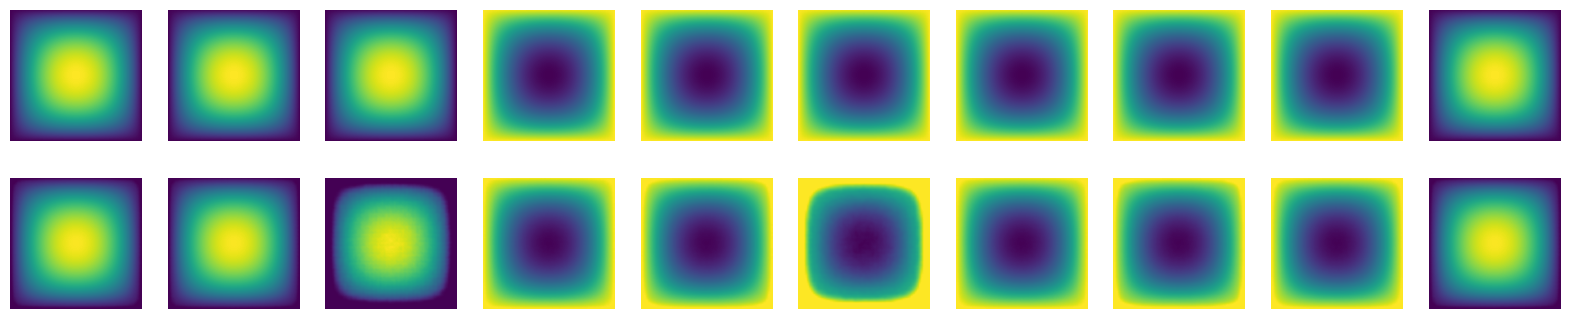

 31%|███       | 31/100 [04:16<09:27,  8.23s/it]

Loss: 697297874.5814697


 32%|███▏      | 32/100 [04:24<09:17,  8.20s/it]

Loss: 744356746.8434504


 33%|███▎      | 33/100 [04:32<09:09,  8.20s/it]

Loss: 783387658.9680511


 34%|███▍      | 34/100 [04:40<09:02,  8.22s/it]

Loss: 693600220.5335463


 35%|███▌      | 35/100 [04:49<08:53,  8.21s/it]

Loss: 691324181.9456869


 36%|███▌      | 36/100 [04:57<08:44,  8.20s/it]

Loss: 736811896.4217253


 37%|███▋      | 37/100 [05:05<08:34,  8.17s/it]

Loss: 612112964.5654953


 38%|███▊      | 38/100 [05:13<08:24,  8.14s/it]

Loss: 658503153.6709266


 39%|███▉      | 39/100 [05:21<08:17,  8.15s/it]

Loss: 597597444.2108626
Loss: 608584185.3610224


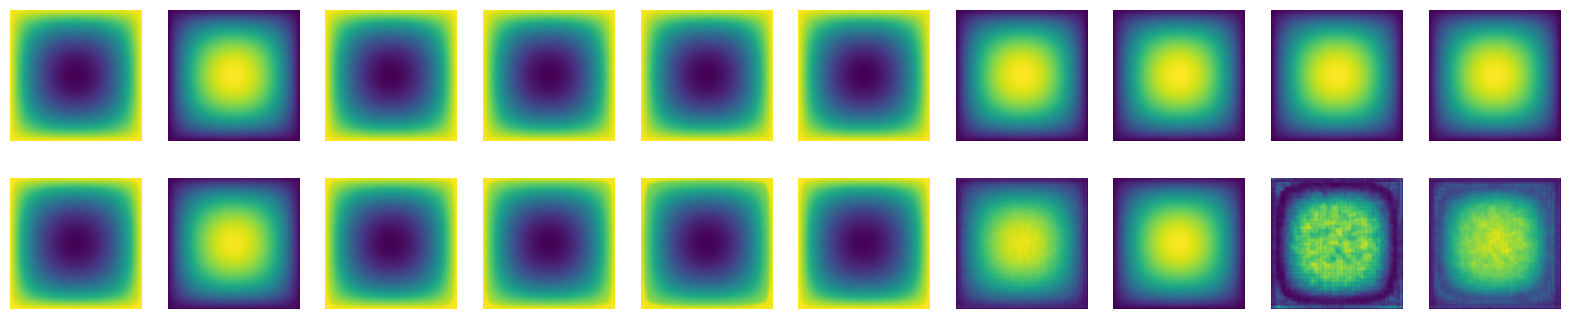

 41%|████      | 41/100 [05:38<08:02,  8.18s/it]

Loss: nan


 42%|████▏     | 42/100 [05:46<07:51,  8.13s/it]

Loss: nan


 43%|████▎     | 43/100 [05:54<07:42,  8.11s/it]

Loss: nan


 44%|████▍     | 44/100 [06:02<07:32,  8.08s/it]

Loss: nan


 45%|████▌     | 45/100 [06:10<07:26,  8.13s/it]

Loss: nan


 46%|████▌     | 46/100 [06:18<07:18,  8.13s/it]

Loss: nan


 47%|████▋     | 47/100 [06:26<07:12,  8.16s/it]

Loss: nan


 48%|████▊     | 48/100 [06:34<07:03,  8.14s/it]

Loss: nan


 49%|████▉     | 49/100 [06:42<06:54,  8.12s/it]

Loss: nan
Loss: nan


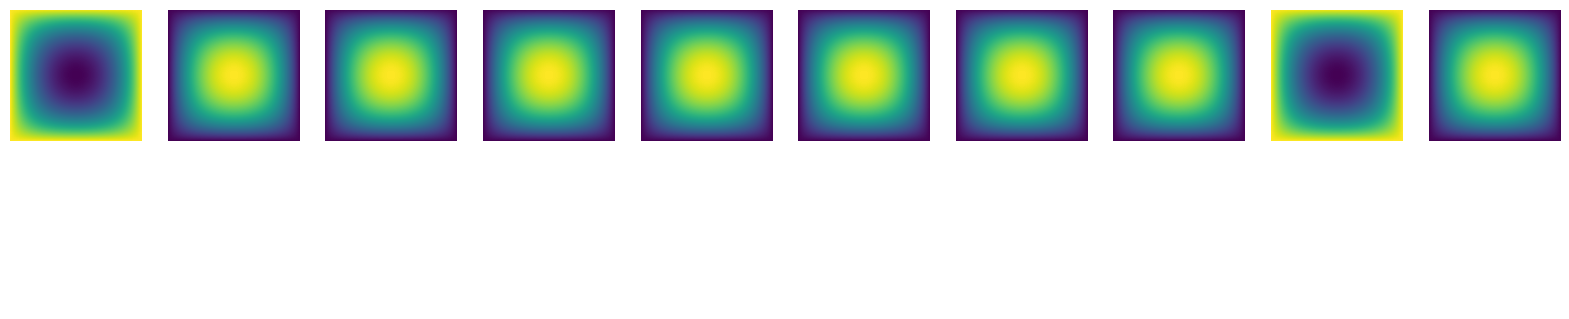

 51%|█████     | 51/100 [06:59<06:42,  8.21s/it]

Loss: nan


 52%|█████▏    | 52/100 [07:07<06:34,  8.23s/it]

Loss: nan


 53%|█████▎    | 53/100 [07:15<06:25,  8.20s/it]

Loss: nan


 54%|█████▍    | 54/100 [07:24<06:16,  8.18s/it]

Loss: nan


 54%|█████▍    | 54/100 [07:28<06:21,  8.30s/it]


KeyboardInterrupt: 

In [9]:
vae_model = VAE(latent_dim=128).to(device)
vae_model.apply(he_weights_init)
optimizer = optim.Adam(vae_model.parameters(), lr=1e-4)

num_epochs = 100
best_loss = float('inf')
train_losses = []
for epoch in tqdm(range(num_epochs)):
    vae_model.train()
    train_loss = 0
    for u_tensor in train_loader:
        u_tensor = u_tensor.to(device)
        optimizer.zero_grad()
        recon_x, mu, logvar, z = vae_model(u_tensor)
        loss = vae_loss(recon_x, u_tensor, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    print(f'Loss: {train_loss}')

    # 10 에폭마다 재구성 이미지 시각화
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            vae_model.eval()
            indices = np.random.choice(len(u_matrices), size=10, replace=False)  # 무작위로 10개의 샘플 선택
            u_tensor = u_matrices[indices]
            u_tensor = torch.tensor(u_tensor).unsqueeze(1).float().to(device)
            recon_x, _, _, _ = vae_model(u_tensor)
            recon_x = recon_x.cpu().numpy()
            
            fig, axes = plt.subplots(2, 10, figsize=(20, 4))
            for i in range(10):
                axes[0, i].imshow(u_tensor[i, 0].cpu(), cmap='viridis')
                axes[0, i].axis('off')
                axes[1, i].imshow(recon_x[i, 0], cmap='viridis')
                axes[1, i].axis('off')
            plt.show()
        vae_model.train()
    
    if train_loss < best_loss:
        best_loss = train_loss
        best_model_wts = vae_model.state_dict()

torch.save(vae_model.state_dict(), 'last_vae_model.pth')
torch.save(best_model_wts, 'best_vae_model.pth')

print(f'Last Loss: {train_loss:.4f} Last vae_model saved to last_vae_model.pth')
print(f'Best Loss: {best_loss:.4f} Best vae_model saved to best_vae_model.pth')

plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Step 2: Latent Space Regression Model

In [ ]:
class LatentSpaceDataset(Dataset):
    def __init__(self, f_matrices, latent_vectors):
        self.f_matrices = f_matrices
        self.latent_vectors = latent_vectors

    def __len__(self):
        return len(self.f_matrices)

    def __getitem__(self, idx):
        f_tensor = torch.tensor(self.f_matrices[idx]).unsqueeze(0).float()  # (1, H, W)
        latent_tensor = torch.tensor(self.latent_vectors[idx]).float()
        return f_tensor, latent_tensor

In [ ]:
class LatentRegressionModel(nn.Module):
    def __init__(self, latent_dim=128):
        super(LatentRegressionModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(64 * 32 * 32, latent_dim)

    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = nn.ReLU()(self.conv2(x))
        x = nn.ReLU()(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
class PoissonDataset(Dataset):
    def __init__(self, u_matrices):
        self.u_matrices = u_matrices

    def __len__(self):
        return len(self.u_matrices)

    def __getitem__(self, idx):
        u_matrix = self.u_matrices[idx]
        u_tensor = torch.tensor(u_matrix).unsqueeze(0).float()  # (1, H, W) 형태로 변환
        return u_tensor

u_matrices = np.load(f'./{u_file_name}')
dataset = PoissonDataset(u_matrices)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

In [ ]:
vae_model.load_state_dict(torch.load('best_vae_model.pth'))
vae_model.eval()

latent_vectors = []
with torch.no_grad():
    for u_tensor in train_loader:
        u_tensor = u_tensor.to(device)
        _, _, _, z = vae_model(u_tensor)
        latent_vectors.append(z.cpu().numpy())

latent_vectors = np.concatenate(latent_vectors, axis=0)
np.save('latent_vectors.npy', latent_vectors)

In [ ]:
f_matrices = np.load(f'./f_dataset.npy')
latent_vectors = np.load('latent_vectors.npy')

dataset = LatentSpaceDataset(f_matrices, latent_vectors)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

In [ ]:
regression_model = LatentRegressionModel(latent_dim=128).to(device)
regression_model.apply(he_weights_init)

optimizer = optim.Adam(regression_model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

num_epochs = 100
best_loss = float('inf')
train_losses = []
for epoch in tqdm(range(num_epochs)):
    regression_model.train()
    train_loss = 0
    for f_tensor, latent_vector in train_loader:
        f_tensor = f_tensor.to(device)
        latent_vector = latent_vector.to(device)
        optimizer.zero_grad()
        predicted_latent = regression_model(f_tensor)
        loss = criterion(predicted_latent, latent_vector)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    print(f'Loss: {train_loss}')
    
    if train_loss < best_loss:
        best_loss = train_loss
        best_model_wts = regression_model.state_dict()

torch.save(regression_model.state_dict(), 'last_regression_model.pth')
torch.save(best_model_wts, 'best_regression_model.pth')

print(f'Last Loss: {train_loss:.4f} Last regression_model saved to last_regression_model.pth')
print(f'Best Loss: {best_loss:.4f} Best regression_model saved to best_regression_model.pth')

plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Step 3: Inference Model

In [ ]:
class InferenceModel(nn.Module):
    def __init__(self, regression_model, vae_model):
        super(InferenceModel, self).__init__()
        self.regression_model = regression_model
        self.vae_model = vae_model

    def forward(self, f_tensor):
        latent_vector = self.regression_model(f_tensor)
        reconstructed_u = self.vae_model.decode(latent_vector)
        return reconstructed_u

regression_model.load_state_dict(torch.load('best_regression_model.pth'))
regression_model.eval()

vae_model.load_state_dict(torch.load('best_vae_model.pth'))
vae_model.eval()

inference_model = InferenceModel(regression_model, vae_model).to(device)

# Test inference with a new f_matrix
f_value = 10  # example f_value
new_f_matrix = np.full(input_shape, f_value)
new_f_tensor = torch.tensor(new_f_matrix).unsqueeze(0).unsqueeze(0).float().to(device)

with torch.no_grad():
    predicted_u = inference_model(new_f_tensor)

predicted_u = predicted_u.squeeze().cpu().numpy()

plt.imshow(predicted_u, cmap='viridis', extent=(0, 1, 0, 1))
plt.colorbar()
plt.title(f'Predicted u for f={f_value}')
plt.show()
